In [1]:
import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

import tams
from shapely.geometry import Polygon
from shapely.geometry import Polygon
from shapely.geometry.polygon import LinearRing
from shapely.geometry.polygon import orient
import pandas as pd
import regionmask
import geopandas as gp
from shapely.geometry import Point

from pathlib import Path
import os
import datetime
import dask
import wrf
import metpy.calc as mpcalc
from metpy.units import units


# Uploading MPAS data with new variables and running CTT WRF-Python 

In [10]:
# Assign times to the file
base = Path("/glade/scratch/knocasio/test_mpas_tams")
paths = sorted(base.glob("diag.2006-09-*"))

dates =[]
# Split path in 2 text
for path in paths:
    s = os.path.split(path)
    ss=s[1][5:24]
    d2 = datetime.datetime.strptime(ss,'%Y-%m-%d_%H.%M.%S')
    dates.append(np.datetime64(d2))

# Read post-processed file 
ds=xr.open_mfdataset("/glade/scratch/knocasio/test_mpas_tams/post_process/deg.25_diag.2006-09*.nc",concat_dim='xtime', combine='nested', parallel=True) 
ds_ter = xr.open_dataset("/glade/scratch/knocasio/test_mpas/ter_deg.25_init.nc",engine="netcdf4")

ds= ds.assign_coords(xtime=dates)
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_new = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon') 
    ds_new_ter = ds_ter.assign_coords(lon=(((ds_ter.lon + 180) % 360) - 180)).sortby('lon') 

In [27]:
#np.broadcast_to((ds_new.t_iso_levels.values/100)[:, np.newaxis, np.newaxis], (27, 720, 1440)).shape

(27, 720, 1440)

In [13]:
%%time

geo = mpcalc.height_to_geopotential(ds_new.z_isobaric.isel(xtime=10))
geo_hgt = geo/9.80665

CPU times: user 6.19 ms, sys: 22 µs, total: 6.21 ms
Wall time: 6.22 ms


In [24]:
%%time

pres_hpa = np.broadcast_to((ds_new.z_iso_levels.values/100)[:, np.newaxis, np.newaxis], (27,8,9)) #(27, 720, 1440))
tkel = ds_new.t_isobaric.isel(xtime=10).transpose("t_iso_levels", "lat", "lon").load()
qv = ds_new.qv_isobaric.isel(xtime=10).transpose("t_iso_levels", "lat", "lon").load()
qcld = ds_new.qc_isobaric.isel(xtime=10).transpose("t_iso_levels", "lat", "lon").load()
height = geo_hgt.transpose("z_iso_levels", "lat", "lon").load()
terrain = ds_new_ter.transpose("lat", "lon").load()
qice = ds_new.qi_isobaric.isel(xtime=10).transpose("t_iso_levels", "lat", "lon").load()


tkel =tkel.sel(lat=slice(0, 2), lon=slice(16,18)) 
qv = qv.sel(lat=slice(0, 2), lon=slice(16,18)) 
qcld = qcld.sel(lat=slice(0, 2), lon=slice(16,18)) 
height = height.sel(lat=slice(0, 2), lon=slice(16,18)) 
terrain = terrain.sel(lat=slice(0, 2), lon=slice(16,18))  #ds_new.ter.isel(xtime=10).load()
qice = qice.sel(lat=slice(0, 2), lon=slice(16,18)) 


CPU times: user 548 ms, sys: 402 ms, total: 950 ms
Wall time: 1.45 s


In [102]:
# Constants
EPS = 0.622
G =  9.81
RD = 287
USSALR = 0.0065 # deg C per m
CELKEL = 273.15
ABSCOEF = .145 
ABSCOEFI = .272 
    
opt_thresh = 1.0
fill_nocloud = False

prs = pres_hpa
tk = tkel.values
ter = terrain.ter.values
ght = height.values
nz = ds_new.z_iso_levels.size
pf = np.zeros_like(tkel)
ctt = np.zeros_like(ter)
qvp = qv.values
qcw = qcld.values
qci = qice.values

# Calculating surface pressure  
ratmix = .001*qvp[0,:,:]
arg1 = EPS + ratmix
arg2 = EPS*(1. + ratmix)
vt = tk[0,:,:]*arg1/arg2 # virtual temp 
agl_hgt =  ght[-1,:,:] - ter[:,:] #ght[:,:,-1] - ter[:,:]
arg1 = -G/(RD*USSALR)
pf[-1,:,:] = prs[0,:,:]*(vt/(vt + USSALR*(agl_hgt)))**(arg1)

# Other pf
for k in range(0, nz-1):
    ripk = nz - k - 1
    pf[k,:,:] = 0.5 * (prs[ripk,:,:] + prs[ripk-1,:,:])

    
opdepthd = 0
k = 0
prsctt = -1

#Integrate downward from model top, calculating path at full
# model vertical levels.
for k in range(1, nz): 
    opdepthu = opdepthd
    ripk = nz - k - 1

    if k != 0:
        dp = 100*(pf[k,:,:] - pf[k-1,:,:])  #! should be in Pa
    else:
        dp = 200*(pf[0,:,:] - prs[-1,:,:])  #! should be in Pa

    opdepthd = opdepthd + (ABSCOEF*qcw[ripk,:,:] + ABSCOEFI*qci[ripk,:,:])*dp/G        
    
    # opdepthd = np.where(opdepthd < opt_thresh, np.nan, opdepthd)
    
    if k == nz - 1:  # top level
        if fill_nocloud is False: 
            prsctt = prs[0,:,:]                   
    else: 
        fac = (1. - opdepthu)/(opdepthd - opdepthu)
        prsctt = pf[k-1,:,:] + fac*(pf[k,:,:] - pf[k-1,:,:])
        prsctt = np.minimum(prs[0,:,:], np.maximum(prs[-1,:,:], prsctt))


ctt = np.where(prsctt > -1, ctt, np.nan)
for k in range(1, nz):          
    ripk = nz - k - 1
    p1 = prs[ripk+1,:,:]
    p2 = prs[ripk,:,:]
    # if prsctt >= p1 and prsctt <= p2:
    fac = (prsctt - p1)/(p2 - p1)
    arg1 = fac*(tk[ripk,:,:] - tk[ripk+1:,:]) - CELKEL
    # ctt[:,:] = tk[ripk+1,:,:] + arg1
    ctt      

/glade/scratch/knocasio/ipykernel_106555/3280535377.py:62: RuntimeWarning: divide by zero encountered in true_divide
  fac = (1. - opdepthu)/(opdepthd - opdepthu)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
%%time

cct = wrf.ctt(  # requires (lev, lat, lon) order
    pres_hpa,
    tkel,
    qv,
    qcld,
    height,
    terrain,
    qice,
    units='K', meta=False,
)

## MPAS OLR data to calculate aprox. cloud temperature

In [3]:
# Assign times to the file
base = Path("/glade/scratch/knocasio/15km_MPAS_IFS_8sept_12utc_Thompson_MYNN") ### GFS/IFS ###
paths = sorted(base.glob("diag.2006-09-08*"))

dates =[]
# Split path in 2 text
for path in paths:
    s = os.path.split(path)
    ss=s[1][5:24]
    d2 = datetime.datetime.strptime(ss,'%Y-%m-%d_%H.%M.%S')
    dates.append(np.datetime64(d2))

ds_IFS=xr.open_mfdataset("/glade/scratch/knocasio/15km_MPAS_IFS_8sept_12utc_Thompson_MYNN/post_process/deg.25_diag.2006-09-08*.nc",
                         concat_dim='xtime', combine='nested', parallel=True) 
ds_IFS= ds_IFS.assign_coords(xtime=dates)

with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_new_IFS = ds_IFS.assign_coords(lon=(((ds_IFS.lon + 180) % 360) - 180)).sortby('lon')

In [25]:
#Calculating temperature from OLR
sb = 5.670374e-8 # Stefan–Boltzmann constant in [ W m^-2 K^-4 ]
tb = (ds_new_IFS.olrtoa/sb )**(1/4)

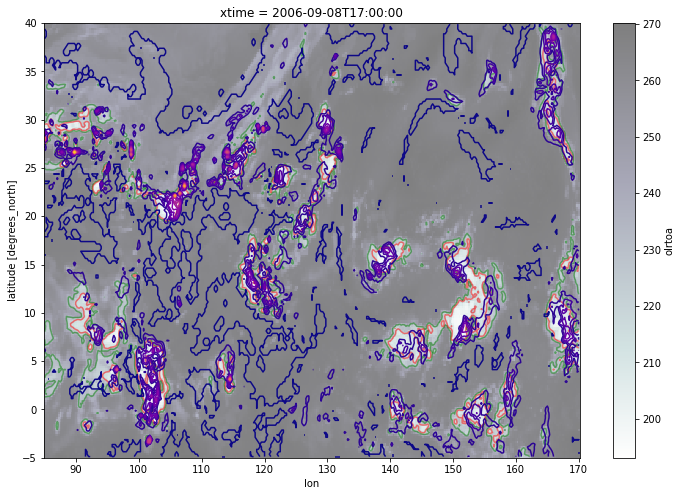

In [65]:
longitudes = (85, 170)
latitudes = (-5, 40) 
tb.isel(xtime=4).sel(lat=slice(-5, 40),lon=slice(85, 170)).plot.contour(x="lon", y="lat", levels =[235], colors="g", size=8, alpha=0.5)
tb.isel(xtime=4).sel(lat=slice(-5, 40),lon=slice(85, 170)).plot.contour(x="lon", y="lat", levels =[219], colors="r", alpha=0.5)
tb.isel(xtime=4).sel(lat=slice(-5, 40),lon=slice(85, 170)).plot(x="lon", y="lat", cmap="bone_r", alpha=0.5)
pr_1new = (ds_new_IFS.rainc.sel(lat=slice(-5, 40), lon=slice(85, 170)) + ds_new_IFS.rainnc.sel(lat=slice(-5, 40), lon=slice(85,170)) ).diff('xtime')  
pr_1new.isel(xtime=4).plot.contour(x="lon", y="lat",levels=20, cmap='plasma')        


data = xr.Dataset(data_vars=dict(tb=tb.sel(lat=slice(-5, 40),lon=slice(85, 170)),precip=(pr_1new)))

In [67]:
## Save as netcdf and compress for space on github 

data.to_netcdf("MPAS_data.nc", encoding={"tb": dict(zlib=True, complevel=9), 
                                         "precip": dict(zlib=True, complevel=9), "lat": dict(zlib=True, complevel=9), "lon": dict(zlib=True, complevel=9)})

## Cutting some of the satellite files to be used for testing and saving as netcdf

In [2]:
#ds=xr.open_dataset("/glade/scratch/knocasio/W_XX-EUMETSAT-Darmstadt,VIS+IR+IMAGERY,MSG1+SEVIRI_C_EUMG_20060901000009.nc", decode_cf=True) 

## Open data and setting decode_cf = True will take care of offset and scale factor issue 
ds=xr.open_mfdataset("/glade/scratch/knocasio/W_XX-EUMETSAT-Darmstadt,VIS+IR+IMAGERY,MSG1+SEVIRI_C_EUMG_20060901*.nc", 
                     concat_dim='time',combine='nested', parallel=True, decode_cf=True) 

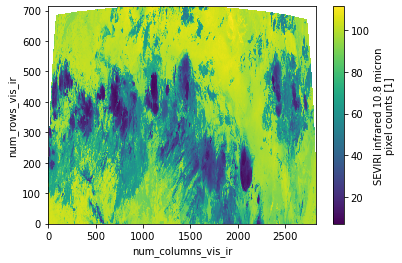

In [11]:
## Assign coordiantes to ch9 to be able to use where to select region of interest 
ch9 = ds.ch9
ch9= ds.ch9.assign_coords(lon=ds.lon, lat=ds.lat)

## Using .where with drop=True will drop all other lats and lons that are not of interest
ch9_new = ch9.where( (ch9.lat >= 0) & (ch9.lat <=20) & (ch9.lon >= -40) & (ch9.lon <=50), drop=True).isel(time=slice(0,6))

## Checking that correct region is selected using plot via xarray 
ch9_new.isel(time=1).plot()

## Save as netcdf and compress for space on github 
ch9_new.to_netcdf("Satellite_data.nc", encoding={"ch9": dict(zlib=True, complevel=9), "lat": dict(zlib=True, complevel=9), "lon": dict(zlib=True, complevel=9)}) 

In [6]:
# ds[["ch9", "lat", "lon"]].ch9.plot(robust=True)
## Cheking on decode_cf = True
#ds.ch9.min().compute()
#xr.open_dataset("/glade/scratch/knocasio/W_XX-EUMETSAT-Darmstadt,VIS+IR+IMAGERY,MSG1+SEVIRI_C_EUMG_20060901000009.nc").ch9.max()

# TAMS

## Identify Clouds 

### Load data & Calculate temp

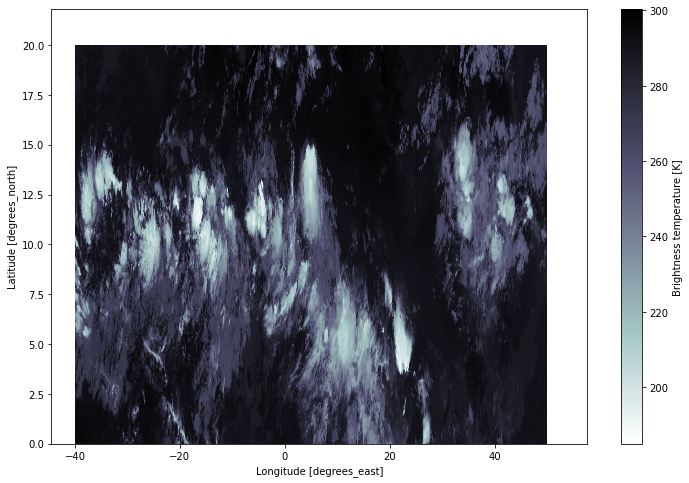

In [2]:
## Load data 
#ds = xr.open_dataset("/glade/scratch/knocasio/Satellite_data.nc")
r = tams.load_example_ir()

## Converting from Radiance to Brightness Temp
#Temp=(( ( 1.43877 ) * ( 930.659 ) )/np.log ( ( ( (1.19104*10**(-5) ) * ( (930.659)**3 ) ) /ds.ch9.values ) + 1 )-0.627)/0.9983;

tb = tams.tb_from_ir(r, 9)
tb.isel(time=0).plot(x="lon", y="lat", cmap="bone_r", size=8)

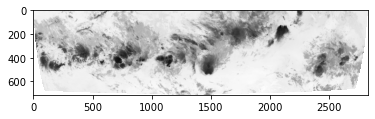

In [32]:
# fig, ax = plt.subplots()
# new = Temp[0,:,:]
# ax.imshow(Temp[0,:,:],cmap=plt.cm.gray)

### Identify contours 

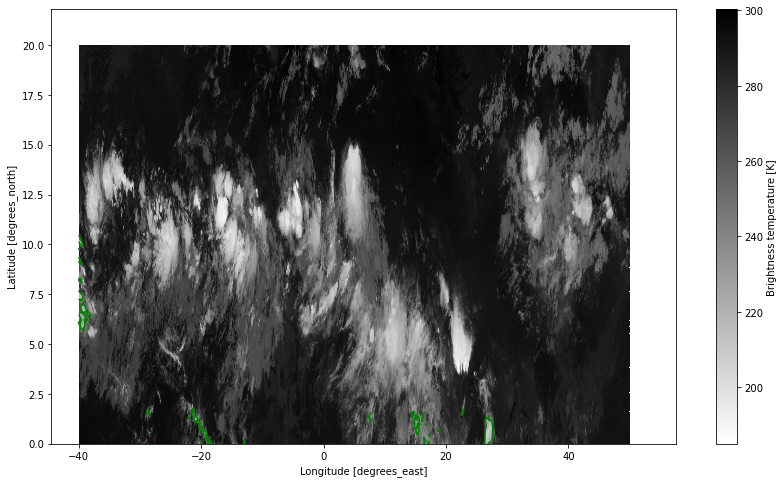

In [3]:
# # Find contours at a constant value of 0.8
# contours_235 = measure.find_contours(Temp[0,:,:],235)
# contours_219 = measure.find_contours(Temp[0,:,:],219)

# # # Display the image and plot all contours found
# fig, ax = plt.subplots()
# ax.imshow(Temp[0,:,:], cmap=plt.cm.gray)

# for contour in contours_235:
#     ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

# ax.axis('image')
# ax.set_xticks([])
# ax.set_yticks([])
# plt.show()

# attempting scaling the image
# x0 = ds.ch9.isel(time=0).lon.values[:,0]
# #dx = ds.ch9.isel(time=0).lon.values[:,-1] - x0
# dx = ds.ch9.isel(time=0).lon.values[:,-1] - x0
# y0 = ds.ch9.isel(time=0).lat.values[0,:]
# dy = ds.ch9.isel(time=0).lat.values[-1,:] - y0

# plt.figure()

# plt.pcolormesh(ds.ch9.isel(time=0).lon, ds.ch9.isel(time=0).lat, Temp[0, :, :],cmap=plt.cm.gray)
# plt.plot(c[:,0]/nx*dx.min() - x0.min(), c[:,1]/ny*dy.min() - y0.min(), "r")


cs = tams.contours(tb.isel(time=0), 235)


fig, ax = plt.subplots(figsize=(14, 8))

tb.isel(time=0).plot(x="lon", y="lat", cmap="gray_r", ax=ax)
for c in cs[:50]:
    ax.plot(c[:, 0], c[:, 1], "g")

 

In [58]:
tb.lon

<xarray.DataArray 'lon' (time: 6, y: 714, x: 2829)>
[12119436 values with dtype=float32]
Coordinates:
    lon      (time, y, x) float32 ...
    lat      (time, y, x) float32 ...
Dimensions without coordinates: time, y, x
Attributes:
    _CoordinateAxisType:  Lon
    standard_name:        longitude
    valid_max:            180.0
    long_name:            Longitude
    valid_min:            -180.0
    units:                degrees_east

## Calculate area in km and testing for "valid" contours

In [4]:
## Testing code 
from IPython.display import display, SVG

for c in cs[:]:
    x = c[:,0].round(7)
    y = c[:,1].round(7)
    r = LinearRing(zip(x, y))
    # print(r.is_closed)
    # r = LinearRing(zip(np.r_[x, x[0]], np.r_[y, y[0]]))
    p0 = r.convex_hull
    # p0 = r.buffer(0.005)
    p = orient(p0)  # counter-clockwise
    if not p.is_valid:
        display(p)
        print(len(p.exterior.coords))
        print(list(p.exterior.coords))

        plt.figure()
        plt.plot(*zip(*p.exterior.coords), "b.-")
        break
else:
    print("all valid")  

all valid


In [5]:
# First use equal rectangular projection
c1 = cs[0];

# Vertices
x = c1[:,0].round(7)
y = c1[:,1].round(7)

# change to km^2 
xdist = 6371*x*(np.pi/180) * np.cos(np.deg2rad(y)); 
ydist = 6371*y*(np.pi/180);

# # Clean invalid contours (according to Shapely) using convexhull 
r = LinearRing(zip(xdist, ydist)) #zip combines the 2 list and LinearRing is the edge 
p0 = r.convex_hull    
p = orient(p0)  # counter-clockwise

# 2 calculate area 
area = p.area    

In [6]:
%%time
# Next: get average temp and std inside each contour

cs_219 = tams.contours(tb.isel(time=0), 219)
c219 = cs_219[0];

r = LinearRing(zip(c219[:,0], c219[:,1])) #zip combines the 2 list and LinearRing is the edge 

gdf = gp.GeoDataFrame(geometry=[r.convex_hull])
lat =tb.isel(time=0).lat.to_series() #tb.isel(time=0).lat.values #c219[:,1]
lon = tb.isel(time=0).lon.to_series()#tb.isel(time=0).lon.values #c219[:,0]

# Create geodataframe from numpy arrays
df = pd.DataFrame({'lon':lon, 'lat':lat})

df['coords'] = list(zip(df['lon'],df['lat']))
df['coords'] = df['coords'].apply(Point)

points = gp.GeoDataFrame(df,geometry='coords',crs=gdf.crs)
pointInPolys = gp.tools.sjoin(points, gdf, predicate='within', how='left')

pnt_LA = points[pointInPolys.index_right==0]

# Plot map with points in LA in red
# base = gdf.boundary.plot(linewidth=1, edgecolor="black")
# points.plot(ax=base, linewidth=1, color="blue", markersize=1)
# pnt_LA.plot(ax=base, linewidth=1, color="red", markersize=8)
# plt.plot(c219[:, 0], c219[:, 1], "g")
# plt.xlim([-40, -39.65])
# plt.ylim([7.29, 7.55])
# plt.show()

data = tb.isel(time=0).to_dataframe()
temp219_mean_inside = pnt_LA.merge(data, how="left").ch9.mean() # left merges the resutls has all the same rows as the left array 
temp219_std_inside = pnt_LA.merge(data, how="left").ch9.std()


CPU times: user 22.2 s, sys: 959 ms, total: 23.2 s
Wall time: 23.6 s


CPU times: user 4.65 s, sys: 171 ms, total: 4.82 s
Wall time: 4.91 s


In [7]:
%%time
# Making a function to get temps for points inside of mask 
def temp_in(tt, gdf):
    # Create geodataframe from numpy arrays
    lat = tt.lat.to_series() #tb.isel(time=0).lat.values #c219[:,1]
    lon = tt.lon.to_series()#tb.isel(time=0).lon.values #c219[:,0]
    df = pd.DataFrame({'lon':lon, 'lat':lat})
    df['coords'] = list(zip(df['lon'],df['lat']))
    df['coords'] = df['coords'].apply(Point)
    points = gp.GeoDataFrame(df,geometry='coords',crs=gdf.crs)
    
    pointInPolys = gp.tools.sjoin(points, gdf, predicate='within', how='left')
    
    pnt_in = points[pointInPolys.index_right==0]
    data = tt.to_dataframe()
    temp219_mean_inside = pnt_in.merge(data, how="left").ch9.mean() # left merges the resutls has all the same rows as the left array 
    temp219_std_inside = pnt_in.merge(data, how="left").ch9.std()
    return (temp219_mean_inside,temp219_std_inside,pnt_in)

# Using just one contour at a time 
t = 0
#for t in range(0,len(tb.time)): 
#cs_219 = tams.contours(tb.isel(time=t), 219)
#for c in range(340,len(cs_219)):
#    c219 = cs_219[c]
tt =tb.isel(time=t)
[temp219_mean_insid,temp219_std_inside,pnt_in]=temp_in(tt,gdf)


CPU times: user 21.8 s, sys: 879 ms, total: 22.7 s
Wall time: 23.1 s


In [9]:
# Zach checked for areas and for 219K indices inside of 235K 

344

In [19]:
# Next, I'll check pyresample and xESMF for smoothing the satellite datat a bit to make calculations faster 